In [2]:
import numpy as np
import nltk
from nltk.corpus import brown
import math
from sklearn import metrics
nltk.download("brown")
nltk.download("universal_tagset")
nltk.download("punkt")

import gensim
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import re
def preprocess_word(word):
  word = word.lower()
  word = re.sub("n't","",word)
  word = re.sub("[0-9]+","1",word)
  return word
preprocess = np.vectorize(preprocess_word)

In [36]:
def most_similar(wv_matrix, vector):
  # wv_matrix is number-of-words x dimension-of-wv
  return np.argmax(KeyedVectors.cosine_similarities(vector, wv_matrix))
  # return np.argmax(wv_matrix@np.reshape(vector, (-1,1)))

In [18]:
google_wv = gensim.downloader.load('word2vec-google-news-300')

In [23]:
google_wv.save("google_wv.wordvectors")

In [4]:
google_wv = KeyedVectors.load("google_wv.wordvectors", mmap='r')

In [26]:
wv_mean = 0
wv_std = 1
dim_wv = 300

In [37]:
class POS_tagger:
  def __init__(self, train_sentences):
    self.sentences = train_sentences
    self.words = []
    self.lexical_probability = None
    self.inference = None

    self.tagset = None
    self.tagset_len = 0
    
    self.vocab = None
    self.word_to_id = None  # dictionary (word : id)
    self.vocab_len = 0
    
    self.word_to_vec = None # the words in corpus vocabulary (num_words x wv_dimension)

    self.smoothing = None   # vectorised function (numpy) for smoothing (in test sentence)
  
  def initialise(self):
    
    for sentence in self.sentences:
      for tupl in sentence:
        self.words.append(tupl)

    self.words = np.array(self.words)
    self.words[:,0] = preprocess(self.words[:,0])

    self.tagset = np.unique(self.words[:,1])
    
    self.vocab, word_count = np.unique(self.words[:,0], return_counts = True)
    # self.vocab = self.vocab[word_count > 1]

    self.word_to_id = dict(zip(self.vocab, np.arange(self.vocab.size)))
    # self.word_to_id["UNK"] = self.vocab.size

    self.vocab_len = len(self.word_to_id)
    self.tagset_len = len(self.tagset)

    self.word_to_vec = np.zeros((self.vocab_len, dim_wv))
    for word in self.vocab:
      if word in google_wv:
        self.word_to_vec[self.word_to_id[word],:] = google_wv[word]
      else:
        self.word_to_vec[self.word_to_id[word],:] = np.random.normal(wv_mean,wv_std,dim_wv)

    def smooth(word):
      if word not in self.word_to_id:
        if word in google_wv:
          wv = google_wv[word]
        else:
          wv = np.random.normal(wv_mean,wv_std,dim_wv)
        return self.vocab[most_similar(self.word_to_vec,wv)]
      else:
        return word
    self.smoothing = np.vectorize(smooth)

    # self.words[:,0] = self.smoothing(self.words[:,0])

    self.lexical_probability = np.zeros((self.tagset_len, self.vocab_len))
    self.inference = np.zeros((self.tagset_len+2, self.tagset_len+2))

  def train(self):
    self.initialise()

    for tag_index in range(self.tagset_len):
      tag = self.tagset[tag_index]
      tokens, count = np.unique(self.words[np.where(self.words[:,1] == tag), 0], return_counts = True)
      token_indices = [self.word_to_id[token] for token in tokens]
      self.lexical_probability[tag_index][token_indices] = count

    self.lexical_probability = self.lexical_probability / self.lexical_probability.sum(1).reshape(self.lexical_probability.shape[0],1)

    for sentence in self.sentences:
      prev_tag = None
      for (word,tag) in sentence:
        if prev_tag == None:
          from_tag = 0
          to_tag =  np.searchsorted(self.tagset,tag) + 1
        elif word in [".","?"]:
          from_tag = np.searchsorted(self.tagset,prev_tag) + 1
          to_tag = self.tagset_len + 1
        else:
          from_tag = np.searchsorted(self.tagset,prev_tag) + 1
          to_tag =  np.searchsorted(self.tagset,tag) + 1
        self.inference[from_tag][to_tag] += 1
        prev_tag = tag
    self.inference[-1,0] = 1
    self.inference = self.inference / self.inference.sum(1).reshape(self.inference.shape[0],1)

  def tag(self,sentence):
    sentence = np.array(sentence, dtype="object")
    sentence = self.smoothing(preprocess(sentence))
    sentence = preprocess(sentence)

    ends_properly = True
    if sentence[-1] not in [".","?","!"]:
      sentence = np.append(sentence, ".")
      ends_properly = False
    
    prob = np.zeros((self.tagset_len,1))
    tags_chain = np.full((self.tagset_len, len(sentence) - 1), -1)
    last_word_tag = None
    
    for i in range(len(sentence)):
      if i == 0:
        prob = self.inference[0][1:-1]
        tags_chain[:,i] = -1
        continue
      
      word = sentence[i-1]
      lp = self.lexical_probability[:, self.word_to_id[word]]
      # if(np.max(prob)<0.0000001):   # to prevent probabilities underflowing to zero
      #   prob=prob/np.max(prob)
      prob = prob*lp

      if i == len(sentence) - 1:
        prob = prob*self.inference[1:-1,-1]
        last_word_tag = np.argmax(prob)
        break
      else:
        p_inf = prob.reshape((self.tagset_len,1))*self.inference[1:-1, 1:-1]
        indices = np.argmax(p_inf, axis = 0)
        prob = p_inf[indices,np.arange(self.tagset_len)]
        tags_chain[:,i] = indices

    tagged_sentence = np.array([[word,""] for word in sentence], dtype="object")
    iter = len(sentence) - 1
    while iter >=0 :
      if iter == len(sentence) - 1:
        tag_index = 0
      else:
        tag_index = last_word_tag
        last_word_tag = tags_chain[last_word_tag, iter]

      tagged_sentence[iter][1] = self.tagset[tag_index]
      
      iter -= 1
    
    if not ends_properly: # remove the full stop we appended
      tagged_sentence = tagged_sentence[:-1]
    
    return tagged_sentence  

In [17]:
frac = 0.8
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_train = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

train_sents = all_sentences[ indices[ : n_train] ]
val_sents = all_sentences[ indices[n_train : ] ]

In [38]:
myTagger = POS_tagger(train_sents)

In [39]:
myTagger.train()

In [40]:
def tag(sentence):  # sentence as a string
  sentence = nltk.tokenize.word_tokenize(sentence)
  tags = myTagger.tag(sentence)[:,1]
  return list(zip(sentence, tags))

tag("Never going to give you up")

[('Never', 'ADV'),
 ('going', 'VERB'),
 ('to', 'PRT'),
 ('give', 'VERB'),
 ('you', 'PRON'),
 ('up', 'PRT')]

In [41]:
pred = []
true = []
for sentence in val_sents:
  sentence = np.array(sentence)
  true = true + list(sentence[:,1])
  if len(sentence) == 1:
    pred = pred + ["."]
  else:
    pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

In [42]:
print(metrics.classification_report(true, pred, digits=4))

              precision    recall  f1-score   support

           .     0.9971    1.0000    0.9985     29631
         ADJ     0.9099    0.9183    0.9141     16617
         ADP     0.9652    0.9672    0.9662     28811
         ADV     0.9023    0.9038    0.9030     11331
        CONJ     0.9935    0.9923    0.9929      7556
         DET     0.9922    0.9855    0.9888     27328
        NOUN     0.9617    0.9620    0.9619     54965
         NUM     0.9731    0.9789    0.9760      2843
        PRON     0.9692    0.9864    0.9777      9930
         PRT     0.9020    0.9063    0.9041      5797
        VERB     0.9675    0.9606    0.9640     36305
           X     0.6597    0.4214    0.5143       299

    accuracy                         0.9642    231413
   macro avg     0.9328    0.9152    0.9218    231413
weighted avg     0.9642    0.9642    0.9642    231413



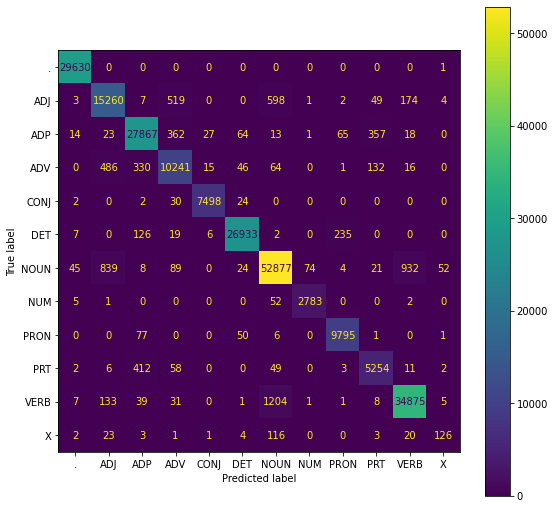

In [43]:
# cm = metrics.confusion_matrix(true,pred)
# print(cm)
# metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = preprocess(myTagger.tagset)).plot(include_values = False)
disp = metrics.ConfusionMatrixDisplay.from_predictions( true, pred, labels=myTagger.tagset, display_labels=myTagger.tagset, values_format='') 
fig = disp.ax_.get_figure() 
fig.set_figwidth(9)
fig.set_figheight(9)  

In [44]:
frac = 0.2
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_val = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

cross_valdation_accuracies = np.zeros(5)

for k in range(5):
  tmp = np.floor(np.arange(n_total)/n_val)
  train_ids = indices[ tmp != k ]
  val_ids = indices[ tmp == k ]
  
  train_sents = all_sentences[ train_ids ]
  val_sents = all_sentences[ val_ids ]

  myTagger = POS_tagger(train_sents)
  myTagger.train()

  pred = []
  true = []
  for sentence in val_sents:
    sentence = np.array(sentence)
    true = true + list(sentence[:,1])
    if len(sentence) == 1:
      pred = pred + ["."]
    else:
      pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

  from sklearn import metrics
  cm = metrics.confusion_matrix(true,pred)

  cross_valdation_accuracies[k] = np.trace(cm)/np.sum(cm)

In [45]:
print(cross_valdation_accuracies)
print(cross_valdation_accuracies.mean())

[0.96424352 0.96325828 0.96440244 0.96463117 0.96430247]
0.9641675736687461
